In [1]:
%cd ../..

c:\Boyko Boev\Stock-Market-Prediction\src


c:\Boyko Boev\Stock-Market-Prediction\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# from mplfinance.original_flavor import candlestick_ohlc

from utils.chart import config_chart
from constants import SP500_TICKER
from models.cnn_v3.cnn_normalize import prepare_data, generate_images, get_images, get_images_dataset, get_classes_and_files, map_classes_and_files, split_train_and_test_data, get_cnn_data

tf.keras.backend.clear_session()


---

## For **prepare_data** function

Описание:
- Приема стринг като аргумент ticker, който представлява кода на акцията или индекса.
- Извиква основната функция get_data за да извлече данните за акцията за периода между предварително зададените START_DATE и END_DATE.
- След извличането на данните, функцията преобразува колоната 'Date' в стринг формат 'YYYY-MM-DD' необходимо за имената на генерираните изображения.
- Подготвеният DataFrame се връща като резултат от функцията.

Цел:
- Извличане на данните за индекс S&P 500 в конкретен период

(5959, 16)
Date             object
Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
Change          float64
Direction         int64
MA10            float64
MA20            float64
MA50            float64
MA100           float64
RSI             float64
Stochastic_K    float64
Stochastic_D    float64
dtype: object


,Date,Open,High,Low,Close,Adj Close,Volume,Change,Direction,MA10,MA20,MA50,MA100,RSI,Stochastic_K,Stochastic_D
99,2000-05-24,1373.859985,1401.750000,1361.089966,1399.050049,1399.050049,1152300000,25.190063,1,1421.276001,1426.065509,1454.346997,1428.297998,44.368469,23.745746,29.372265
100,2000-05-25,1399.050049,1411.650024,1373.930054,1381.520020,1381.520020,984500000,-17.530029,0,1418.646997,1421.895508,1454.134597,1427.560999,41.539809,19.487574,22.178108
101,2000-05-26,1381.520020,1391.420044,1369.750000,1378.020020,1378.020020,722600000,-3.500000,0,1414.353003,1418.175006,1452.525598,1427.346998,40.978078,22.968362,22.067228
102,2000-05-30,1378.020020,1422.449951,1378.020020,1422.449951,1422.449951,844200000,44.429932,1,1411.362000,1415.885004,1451.685198,1427.550398,50.186817,30.103998,24.186645
103,2000-05-31,1422.439941,1434.489990,1415.500000,1420.599976,1420.599976,960500000,-1.839966,0,1406.817993,1414.600500,1450.964597,1427.721898,49.838139,42.021155,31.697838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6053,2024-01-25,4886.660156,4898.149902,4869.339844,4894.160156,4894.160156,4020430000,7.500000,1,4816.775049,4781.978076,4677.269023,4507.758813,72.932465,92.601030,93.015869
6054,2024-01-26,4888.910156,4906.689941,4881.470215,4890.970215,4890.970215,3353400000,2.060059,1,4827.848047,4787.447583,4686.857432,4511.510815,72.142640,90.749789,91.389010
6055,2024-01-29,4892.950195,4929.310059,4887.399902,4927.930176,4927.930176,3525160000,34.979980,1,4842.258057,4794.676587,4695.502031,4515.821816,75.458828,95.820406,93.057075
6056,2024-01-30,4925.890137,4931.089844,4916.270020,4924.970215,4924.970215,3836130000,-0.919922,0,4858.157080,4802.433594,4703.943838,4520.416719,74.691975,96.309402,94.293199


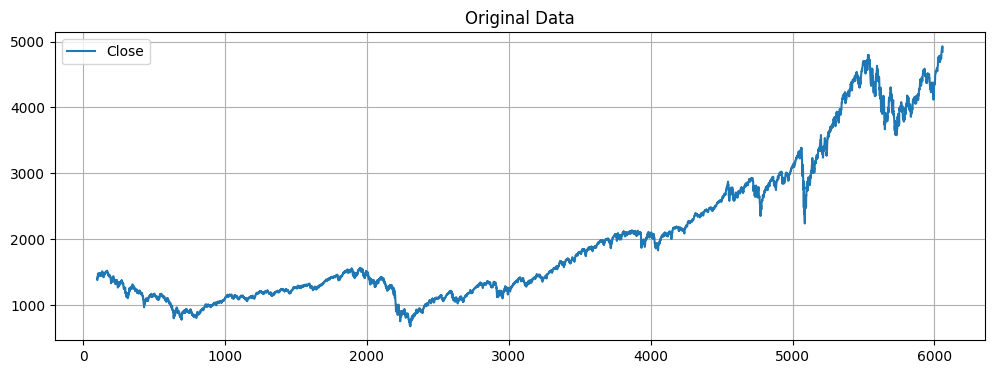

In [3]:
data = prepare_data(SP500_TICKER)


# Show data
print(data.shape)
print(data.dtypes)

plt = config_chart('Original Data')
plt.plot(data.Close)
plt.legend(['Close'])

data


---
 

## For **generate_images** function

Описание:

- Приема DataFrame data като аргумент, който съдържа финансови данни.
- Извлича подмножество от данните (image_data) за визуализация и създава копие, за да не промени оригиналните данни.
- (num_candles) определя броя на свещите, които ще бъдат включени във всяко генерирано изображение.
- Създава се нова фигура (fig) и ос (ax) за всяко изображение с размер 2x2 инча.
- Осите се изключват с ax.set_axis_off() за по-чиста визуализация.
- Извлича се подмножество от данни (formation_data) за текущата итерация на цикъла
- Функцията mpf.plot от библиотеката mplfinance се използва за да се генерира изображение със свещи (type='candle'), като се изключва показването на обема (volume=False) и се посочва оста за визуализацията (ax=ax).
- Директорията за запазване на изображенията се съхранява в предварително дефинирана константа IMAGE_DIRECTORY.
- Датата от първия ред на formation_data се използва за да се генерира уникално име на файла за всяко изображение (формат: YYYY-MM-DD.png).
- Функцията plt.savefig записва изображението като PNG файл с резолюция 75 dpi.

Цел:
- Генериране на изображения на candlesticks графика използвайки цената (Open, High, Low, Close)

In [4]:
# generate_images(data)



---

## For **get_images** function

Описание:

- Използва предварително зададена константа IMAGE_DIRECTORY, която сочи към директорията съдържаща изображенията.
- Функцията създава обект ImageDataGenerator от библиотеката Keras (keras.preprocessing.image), който се използва за зареждане на изображенията
- Методът flow_from_directory зарежда изображенията, като се посочва директорията (IMAGE_DIRECTORY).
- Заредените изображения се връщат като обект ImageDataGenerator.

Цел:
- Зареждане на изображенията

Found 1980 images belonging to 5 classes.


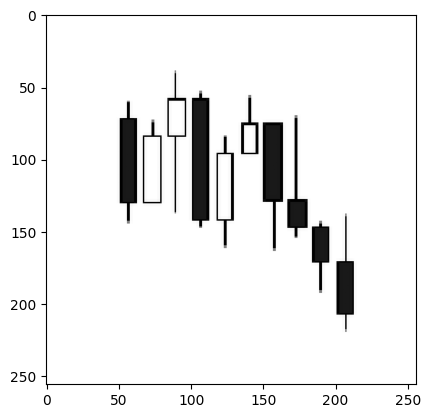

In [19]:

images = get_images()

img = images.__next__()[0]
plt.imshow(img[4] / 255.0)

images


---

## For **get_classes_and_files** function

Описание:

- Използва предварително зададена константа IMAGE_DIRECTORY, която сочи към директорията съдържаща изображенията, организирани по класове (поддиректории).
- Функцията използва os.listdir за да извлече списък с имената на директориите в IMAGE_DIRECTORY. Тези имена се считат за класове на изображенията.
- Цикълът с comprehension се използва за да се създаде списък (folders) съдържащ пътищата към всяка директория (клас). Пътят се конструира с помощта на os.path.join.
- Името на класовете (classes) и пътищата към изображенията (folders) се конвертират в NumPy ndarrays за по-нататъшна обработка.
- Функцията връща тези ndarrays като резултат.

Цел:
- Извличане на всички класове
- Извличане на директорията на всяка папка с изображения

In [6]:
classes, folders = get_classes_and_files()

print(len(classes))
print(classes)

print(len(folders))
print(folders)


5
['bearish_reverse' 'bearish_trend' 'bullish_reverse' 'bullish_trend'
 'neutral']
5
['models/cnn_v3/images/bearish_reverse'
 'models/cnn_v3/images/bearish_trend'
 'models/cnn_v3/images/bullish_reverse'
 'models/cnn_v3/images/bullish_trend' 'models/cnn_v3/images/neutral']



---

## For **map_classes_and_files** function

Описание:

- Функцията map_classes_and_files обработва списъци с имена на класове (classes) и пътища към директории (folders).
- Функцията извлича файловете от всяка директория и създава списъци all_files и all_classes.
all_files съдържа пътищата към всички файлове.
all_classes съдържа повтарящи се имена на класове за всяко изображение в директорията.
- Речник class_mapping се създава, за да съпостави всяко уникално име на клас с негов идентификатор.
- Цикълът преминава през all_classes и използва речника class_mapping за да замени имената на класове с техните идентификатори. Резултатът се съхранява в all_class_ids.
- Накрая функцията връща all_files и all_class_ids.

Цел:
- Извличане на пътищата към всяко изобрацение
- Съпоставяне на класови идентификатори към изображенията. Идентификатора за клас е в числов вид подходящ за модела.

In [7]:
all_files, all_class_ids = map_classes_and_files(classes, folders)

print(all_files.shape)
print(all_files[0])

print(all_class_ids.shape)
print(all_class_ids[0])

(1980,)
models/cnn_v3/images/bearish_reverse\2000-06-20.png
(1980,)
0



---

## For **get_images_dataset** function

Описание:

- Функцията get_images_dataset приема два NumPy ndarrays като аргументи:
all_files: ndarray съдържащ пътищата към изображенията.
class_ids: ndarray съдържащ идентификатори на класовете за всяко изображение.
- Функцията използва цикъл с comprehension, за да прочете изображенията от файловете, използвайки предварително дефинираната функция read_images.
- Прочетените изображения се събират в списък, който след това се конвертира в NumPy ndarray (images).
- Функцията връща резултат, съдържащ ndarrays за изображенията и класовете

Цел:
- Прочитане на изобржаженията във вид подходящ за работа с модела

(1980, 256, 256, 4)
(1980,)
Class 0: count 146
Class 1: count 302
Class 2: count 102
Class 3: count 420
Class 4: count 1010


Text(0.5, 1.0, 'bearish_reverse')

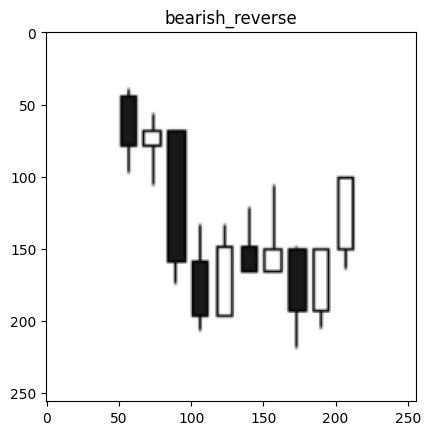

In [8]:
images, labels = get_images_dataset(all_files, all_class_ids)


print(images.shape)
print(labels.shape)

unique_values, counts = np.unique(labels, return_counts=True)
for value, count in zip(unique_values, counts):
  print(f"Class {value}: count {count}")

plt.imshow(images[0])
plt.title(classes[labels[0]])



---

## For **split_train_and_test_data** function

Описание:
- Функцията приема два NumPy ndarray като вход:
    - x: Масив, съдържащ характеристиките на данните.
    - y: Масив, съдържащ целевите етикети на данните.
- Функцията връща речник, съдържащ три други речника:
    - 'train': Речник, съдържащ тренировъчните данни (70% от x и y):
        - 'x': Тренировъчните характеристики.
        - 'y': Тренировъчните етикети.
    - 'test': Речник, съдържащ тестовите данни (20% от x и y)::
        - 'x': Тестовите характеристики.
        - 'y': Тестовите етикети.
    - 'predict': Речник, съдържащ данните за прогнозиране (10% от x и y)::
        - 'x': Характеристиките за прогнозиране.
        - 'y': Етикетите за прогнозиране.
- Използва се сечение, за да се извлекат съответните тренировъчни, тестови и прогнозни набори от оригиналните масиви x и y.

Цел:
- Разделяне на данните (x и y) в тренировъчни, тестови и прогнозни

In [9]:
train_dataset, test_dataset, predict_dataset = split_train_and_test_data(images, labels)


print(train_dataset["x"].shape)
print(train_dataset["y"].shape)

print(test_dataset["x"].shape)
print(test_dataset["y"].shape)

print(predict_dataset["x"].shape)
print(predict_dataset["y"].shape)

(1584, 256, 256, 4)
(1584,)
(198, 256, 256, 4)
(198,)
(198, 256, 256, 4)
(198,)



---

## For **get_cnn_data** function

Описание:

- Функцията get_cnn_data е предназначена да подготви набор от изображения и техните етикети за използване в Конволюционна невронна мрежа (CNN).
- Процеси:
    - Извличане на информация за класове
    - Съпоставяне на класове и файлове
    - Зареждане и предварителна обработка на изображения
    - Разбъркване на изображения и етикети
    - Разделяне на данните на тренировъчни, тестови и прогнозни набори
    - Връщане на набори от данни
- Функцията get_cnn_data връща трите речника, съдържащи подготвените тренировъчни, тестови и прогнозни набори от данни.

Цел:
- Представяне на данните в готов вид за обучение и тестване на модела


In [10]:
train, test, predict = get_cnn_data(SP500_TICKER)

In [11]:

print(len(train["x"]))
print(len(train["y"]))

unique_values, counts = np.unique(train["y"], return_counts=True)
for value, count in zip(unique_values, counts):
  print(f"Class {value}: count {count}")


1584
1584
Class 0: count 110
Class 1: count 243
Class 2: count 77
Class 3: count 341
Class 4: count 813


In [12]:
print(len(test["x"]))
print(len(test["y"]))

unique_values, counts = np.unique(test["y"], return_counts=True)
for value, count in zip(unique_values, counts):
  print(f"Class {value}: count {count}")


198
198
Class 0: count 18
Class 1: count 24
Class 2: count 13
Class 3: count 43
Class 4: count 100


In [13]:
print(len(predict["x"]))
print(len(predict["y"]))

unique_values, counts = np.unique(predict["y"], return_counts=True)
for value, count in zip(unique_values, counts):
  print(f"Class {value}: count {count}")


198
198
Class 0: count 18
Class 1: count 35
Class 2: count 12
Class 3: count 36
Class 4: count 97
